In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j
!pip install ucimlrepo

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,735 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,339 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,068 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis

'/usr/local/lib/python3.10/dist-packages/pyspark'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer, PolynomialExpansion, PCA
from pyspark.sql.functions import col,isnan, when, count, udf, row_number,expr, skewness, log, countDistinct,monotonically_increasing_id, mean,stddev,min,max
from pyspark.sql.types import StringType, IntegerType,DoubleType
from pyspark.sql import Window
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, LinearSVC, NaiveBayes, MultilayerPerceptronClassifier,RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator ,RegressionEvaluator
from imblearn.over_sampling import SMOTE
from pyspark.ml.stat import Summarizer
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# Get the spark session
spark = SparkSession.builder.appName("Diabetes").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Define the random state
random_state = 42

### The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the early readmission of the patient within 30 days of discharge.

### Data exploration

In [ ]:
# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

# data (as pandas dataframes)
df = diabetes_130_us_hospitals_for_years_1999_2008.data

# convert pandas Dataframe into pyspark.sql.Dataframe
concat = pd.concat([df.ids, df.features,df.targets], axis=1)
df = spark.createDataFrame(concat)

/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [ ]:
# Shape
shape = (df.count(), len(df.columns))
print("Shape: ",shape)

Shape:  (101766, 50)


In [ ]:
# Show the features
print(df.printSchema())

root
 |-- encounter_id: long (nullable = true)
 |-- patient_nbr: long (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: long (nullable = true)
 |-- discharge_disposition_id: long (nullable = true)
 |-- admission_source_id: long (nullable = true)
 |-- time_in_hospital: long (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: long (nullable = true)
 |-- num_procedures: long (nullable = true)
 |-- num_medications: long (nullable = true)
 |-- number_outpatient: long (nullable = true)
 |-- number_emergency: long (nullable = true)
 |-- number_inpatient: long (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: long (nullable = true)
 |-- max_glu_serum: string (nullable = tru

In [ ]:
# Show a description of the whole dataset
stats = df.describe(df.columns)
stats.show()

+-------+--------------------+--------------------+---------------+---------------+--------+--------+------------------+------------------------+-------------------+-----------------+----------+--------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------+------+------+------------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|summary|        encounter_id|         patient_nbr|           race|         gender|     age|  weight| admission_type_id|discharge_disposition_id|admission_source_id| time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|    num_procedures|   nu

In [ ]:
# Show a description per class

label_distinct = df.select('readmitted').distinct().collect()

for label in label_distinct:
  label_x = df.filter(col('readmitted') == label.readmitted)
  print("{} statistics".format(label.readmitted))
  label_x.describe(label_x.columns).show()
  print('-'*40)

>30 statistics
+-------+--------------------+-------------------+---------------+------+--------+--------+------------------+------------------------+-------------------+-----------------+----------+--------------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------+------+------+------------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|summary|        encounter_id|        patient_nbr|           race|gender|     age|  weight| admission_type_id|discharge_disposition_id|admission_source_id| time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|    num_procedures|  num_medica

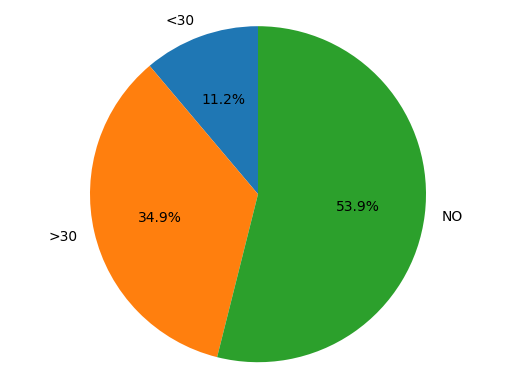

In [ ]:
# Calculate frequencies
frequency_label = df.groupBy("readmitted").count().orderBy("readmitted")

# Convert to Pandas DataFrame
pandas_df = frequency_label.toPandas()

plt.pie(pandas_df['count'], labels=pandas_df['readmitted'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

In [ ]:
plt.show()

Let's explore all the unique values of the features

In [ ]:
max_length = 200

for column in df.columns:
    unique_values = df.select(column).distinct().collect()
    unique_values_list = [row[column] for row in unique_values]
    if len(str(unique_values_list) )<=200:
        print(f"{column}: {str(unique_values_list)}")
    else:
        print(f"{column}: {str(unique_values_list)[:max_length]} ...")

encounter_id: [3712782, 4129332, 5243178, 8282970, 8973804, 9240906, 10128264, 11296476, 12457776, 12559926, 12561348, 13055892, 14592780, 14803422, 16240908, 17428164, 17699964, 18080190, 18548208, 21409206, 21576 ...
patient_nbr: [108453753, 96165, 55426896, 3616155, 3210228, 22668696, 3423933, 14967477, 3688560, 7303995, 2156832, 6921432, 23794407, 4951764, 4811301, 91565334, 76337586, 10422, 18035145, 924264, 6548697, 104792 ...
race: ['Caucasian', 'Other', 'AfricanAmerican', 'NaN', 'Hispanic', 'Asian']
gender: ['Female', 'Unknown/Invalid', 'Male']
age: ['[70-80)', '[90-100)', '[40-50)', '[10-20)', '[20-30)', '[30-40)', '[0-10)', '[80-90)', '[50-60)', '[60-70)']
weight: ['[150-175)', '[125-150)', '[0-25)', '[25-50)', '[75-100)', '[175-200)', 'NaN', '[100-125)', '>200', '[50-75)']
admission_type_id: [7, 6, 5, 1, 3, 8, 2, 4]
discharge_disposition_id: [19, 22, 7, 25, 6, 9, 27, 17, 28, 5, 1, 10, 3, 12, 8, 11, 2, 4, 13, 18, 14, 15, 23, 20, 16, 24]
admission_source_id: [7, 6, 9, 17, 5, 1

As we can see the columns: "examide" and "citoglipton" have only one unique value. We'll drop these columns because they don't play any relevant role in term of classification.
Moreover we will drop all the rows having NaN as race and "Unknown/Invalid" as genre because we can make no distinction of patients based on non defined values for these features.

### Feature Selection

There are multiple rows referring to same patient. One of the assumptions of the Logistic Classifier is that the observations need to
be considered as statistically independent, something that cannot be granted in this case. Let's then take only the first inpatient for simplicity and then drop the column "encounter_id" and "patient_nmbr".

In [ ]:
print("Rows in the dataset are {}".format(shape[0]))
print("Number of patients are {}".format(df.select("patient_nbr").distinct().count()))

Rows in the dataset are 101766
Number of patients are 71518


In [ ]:
# Define a window specification based on the "ID" column
window_spec = Window.partitionBy("patient_nbr").orderBy("patient_nbr")

# Assign row numbers to each partition based on the window specification
df_with_row_number = df.withColumn("row_number", row_number().over(window_spec))

# Filter out rows where the row number is 1 (keeping only the first occurrence of each "ID")
df = df_with_row_number.filter(col("row_number") == 1).drop("row_number")

shape = (df.count(), len(df.columns))
print("The dataset now has {} rows".format(shape[0]))

df = df.drop(col('encounter_id') , col('patient_nbr'))

The dataset now has 71518 rows


As said we're gonna drop the columns having a single value

In [ ]:
# Calculate the number of distinct values for each column
distinct_counts = df.select([countDistinct(col_name).alias(col_name) for col_name in df.columns]).first().asDict().items()

# Select columns where the number of distinct values is equal to 1
single_value_columns = [col_name for col_name,value in distinct_counts if value == 1]

print("One distinct value columns: " , single_value_columns)

df = df.drop(*single_value_columns)

One distinct value columns:  ['examide', 'citoglipton', 'glimepiride-pioglitazone']


We drop all the rows where gender = 'NaN' and race = 'Unknown/Invalid'

In [ ]:
df = df.filter((col("race") != "NaN")  & (col("gender")!= "Unknown/Invalid"))
df_shape = (df.count(), len(df.columns))
print("{} columns have been eliminated".format(shape[0]-df_shape[0] , shape[1]-df_shape[1]))
print("The new shape is :" , df_shape)
shape = df_shape

1949 columns have been eliminated
The new shape is : (69569, 45)


Regarding the remaining attributes:
Check wheter there are columns having null or NaN values and eventually let's count them

In [ ]:
missing_values= df.select([(count(when(((col(c) == '' ) | isnan(c)) | (col(c) == 'NaN'), c ))).alias(c) for c in df.columns])
mv = missing_values.first().asDict().items()


# Gets all the columns that have a number of Nulls higher than 20% of the total values
mv = missing_values.select([col_name for col_name,value in mv if value > shape[0] *1/5])


mv.show()

+------+----------+-----------------+
|weight|payer_code|medical_specialty|
+------+----------+-----------------+
| 66851|     30522|            33479|
+------+----------+-----------------+



The columns A1Cresult and max_glu_serum contemplate the presence of missing values. Their description is:
- A1Cresult : was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal”
if the result was less than 7%, and “none” if not measured.
- max_glu_serum: Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,”
“normal,” and “none” if not measured.

- Weight attribute was considered to be too sparse and it was not included in further analysis.
- payer_code and medical_specialty were removed since they had a high percentage of missing values so they were not considered relevant to the outcome.

In [ ]:
#eliminate weigth and payer_code
df = df.drop(col('payer_code'),col('weight'),col('medical_specialty'))

print("there are {} columns".format(len(df.columns)))

there are 42 columns


### Data Preparation


It's noticeable that a lot of features are string, we need to convert them in a numeric format.

The column diag_1,diag_2,diag_3 represent ICD-9 codes which can be classified in categories.
reference to this page for more info: https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9

In [ ]:
# Mapping diag_1, diag_2,diag_3
def diag_label(x):
    try:
        value = int(x)
        if 1 <= value <= 139.9:
            return 1  # Infection and Parasitic Diseases
        elif 140 <= value <= 239.9:
            return 2  # Neoplasms
        elif 240 <= value <= 279.9:
            return 3  # Endocrine, Nutritional and Metabolic Diseases and Immunity Disorders
        elif 280 <= value <= 289.9:
            return 4  # Diseases of Blood and Blood Forming Organs
        elif 290 <= value <= 319:
            return 5  # Mental Disorders
        elif 320 <= value <= 389.9:
            return 6  # Diseases of Nervous System and Sense Organs
        elif 390 <= value <= 459.9:
            return 7  # Diseases of the Circulatory System
        elif 460 <= value <= 519.9:
            return 8  # Diseases of the Respiratory System
        elif 520 <= value <= 579.9:
            return 9  # Diseases of the Digestive System
        elif 580 <= value <= 629.9:
            return 10  # Diseases of the Genitourinary System
        elif 630 <= value <= 676.9:
            return 11  # Complications of Pregnancy, Childbirth and the Puerperium
        elif 680 <= value <= 709.9:
            return 12  # Diseases of the Skin and Subcutaneous Tissue
        elif 710 <= value <= 739.9:
            return 13  # Diseases of the Musculoskeletal System and Connective Tissue
        elif 740 <= value <= 759.9:
            return 14  # Congenital Anomalies
        elif 760 <= value <= 779.9:
            return 15  # Certain Conditions Originating in the Perinatal Period
        elif 780 <= value <= 799.9:
            return 16  # Symptoms, Signs and Ill-defined Conditions
        elif 800 <= value <= 999.9:
            return 17  # Injury and Poisoning
    except ValueError as e:
        return 0 #For values starting with a letter

In [ ]:
# Define the label_condition function as a UDF
label_condition_udf = udf(diag_label, IntegerType())

# Apply the UDF to multiple columns
result = df.select(
    "*",
    label_condition_udf(df["diag_1"]).alias("diag_1_label"),
    label_condition_udf(df["diag_2"]).alias("diag_2_label"),
    label_condition_udf(df["diag_3"]).alias("diag_3_label")
)
df = result.drop(col("diag_1") , col("diag_2"), col("diag_3"))


Regarding the feature that we are interestid to predict which is "readmitted", we can see that there are three distinct values: [<30 , >30, NO]. Since we are specifically interested whether a certain patient has been readmitted within 30 days, we will convert the label "<30" in the label "NO" in order to obtain a binary classification problem which is simpler to treat.

In [ ]:
df = df.withColumn('readmitted', when(col('readmitted') == '>30' , 'NO').otherwise(col('readmitted')))
df.select("readmitted").distinct().show()

+----------+
|readmitted|
+----------+
|        NO|
|       <30|
+----------+



At this point let's encode every other categorical feature with a StringIndexer to turn all the nominal values into numeric values.

In [ ]:
# Get the columns that are of StringType
categorical_columns = [col_name for col_name, col_type in df.dtypes if col_type == 'string']

# Create a pipeline to apply StringIndexer to each categorical column
indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_encoded") for col_name in categorical_columns]
pipeline = Pipeline(stages=indexers)

# Fit and transform the DataFrame using the pipeline
df_encoded = pipeline.fit(df).transform(df)

# Drop the original categorical columns
df_encoded = df_encoded.drop(*categorical_columns)

df_encoded[df_encoded.columns].show()


+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+----------------+------------+------------+------------+------------+--------------+-----------+---------------------+-----------------+-----------------+-------------------+-------------------+----------------------+-------------------+---------------------+-----------------+-----------------+-------------------+--------------------+---------------------+----------------+----------------+--------------------+------------------+---------------+---------------------------+---------------------------+-------------------------------+------------------------------+--------------+-------------------+------------------+
|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|number_diagn

In [ ]:
stats = df_encoded.describe(df_encoded.columns)
stats.show()

+-------+------------------+------------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+---------------------+------------------+-------------------+-------------------+--------------------+----------------------+--------------------+---------------------+------------------+-------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------------------+---------------------------+-------------------------------+------------------------------+-------------------+-------------------+------------------+
|summary| admission_type_id|discharge_disposition_id|admission_source_id|  time_in_hospital|num_lab_procedures|

In [ ]:
cols = df_encoded.columns[:-1]
labelCol = 'readmitted_encoded'
featuresCol = 'features'
assembler = VectorAssembler(inputCols=cols, outputCol=featuresCol)
df_encoded = assembler.transform(df_encoded)

Standard Scaler

In [ ]:
# Standard Scaler (if applied)
def extract(row):
  return (row.readmitted_encoded,row.scaled_features,) + tuple(row.scaled_features.toArray().tolist())


scale_dataset = False
if scale_dataset:
  scaler = StandardScaler(inputCol = 'features', outputCol = "scaled_features")
  scaler_model = scaler.fit(df_encoded.select("features"))
  df_scaled = scaler_model.transform(df_encoded)
  # to standardize the dataset and replace the default values with the standardised ones
  cols_to_keep_unscaled = ['readmitted_encoded', "scaled_features"]
  df_scaled = df_scaled.select(*cols_to_keep_unscaled, "scaled_features").rdd.map(extract).toDF(cols_to_keep_unscaled + cols)
  df_encoded = df_scaled(*df_scaled.columns)
  featuresCol = 'scaled_features'

Train and Test split

In [ ]:
train_data, test_data = df_encoded.randomSplit([0.7, 0.3], seed=random_state)

### Decision Tree

In [ ]:
# Logistic regression
dt = DecisionTreeClassifier(featuresCol=featuresCol, labelCol=labelCol)
dt_preds = dt.fit(train_data).transform(test_data)

In [ ]:
# Calculate True Positive, False Positive, and False Negative
true_positive = dt_preds.filter((dt_preds[labelCol] == 1) & (dt_preds['prediction'] == 1)).count()
false_positive = dt_preds.filter((dt_preds[labelCol] == 0) & (dt_preds['prediction'] == 1)).count()
false_negative = dt_preds.filter((dt_preds[labelCol] == 1) & (dt_preds['prediction'] == 0)).count()

# Calculate Sensitivity, Precision, and Recall
recall = true_positive / (true_positive + false_negative)
precision = true_positive / (true_positive + false_positive)

# EValuator
evaluator = BinaryClassificationEvaluator(labelCol=labelCol)

# Accuracy
accuracy = evaluator.evaluate(dt_preds)
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1_score: " , 2*precision*recall/(precision + recall))


Accuracy 0.47598799295381433
Recall: 0.005324813631522897
Precision: 0.3333333333333333
F1_score:  0.010482180293501049


In [ ]:
def plot_frequencies(dataset, title='',xlabel = '', ylabel=''):
  # Extract data from the "" column
  data = dataset.rdd.flatMap(lambda x: x).collect()
  # Specify the colors for each bar
  possible_colors = ['skyblue', 'salmon', 'lightgreen', 'orchid', 'cornflowerblue', 'lightcoral', 'palegreen', 'mediumorchid', 'deepskyblue', 'lightpink']
  bins = [*range(dataset.distinct().count() +1)]
  # Plot histogram with individually colored bars
  n, bins, patches = plt.hist(data, bins=bins, edgecolor='black')
  # Set colors for each bar individually
  for i in range(len(patches)):
      patches[i].set_facecolor(possible_colors[i])
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.xticks(bins[:-1])  # Set x-axis ticks to match specified bins
  plt.show()

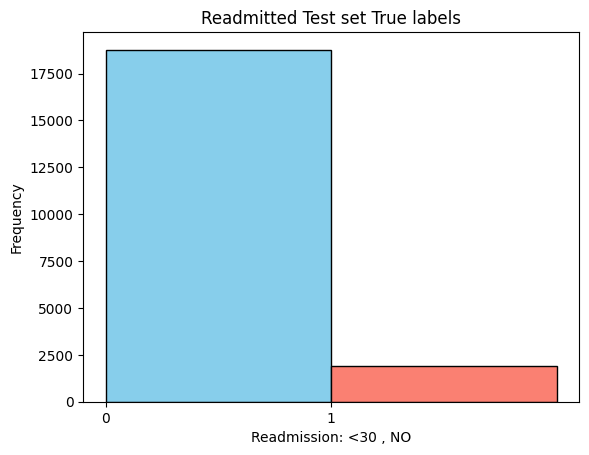

In [ ]:
plot_frequencies(test_data.select(labelCol), title="Readmitted Test set True labels", xlabel="Readmission: <30 , NO",ylabel="Frequency")

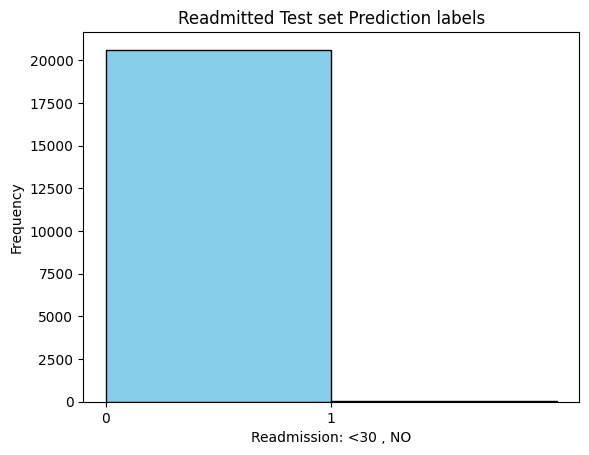

In [ ]:
plot_frequencies(dt_preds.select('prediction'), title="Readmitted Test set Prediction labels", xlabel="Readmission: <30 , NO",ylabel="Frequency")

The model is performing poorly in term of F1_score, indeed it is overfitting on the majority class label which is 0. This happens obviously because the label column (readmitted_encoded) is definitely unbalanced as we can see from the label distribution.

To rebalance the class we can use resampling techniques. However, dealing with health-related datasets is a delicate situation because of a rare occurrence of certain patologies or clinical conditions. Among the most common solutions, one can proceed by undersampling the most frequent class labels (with the risk of losing some valuable piece of information), or oversampling the minority class (with the risk of overfitting, introduction of noise or loss of diversity of minorities).

We decided to apply both oversampling and undersampling keeping a low ratio to avoid side effects of both the methods

In [ ]:
# Separate the label column from the dataset and the scaled_features before sampling
X = df_encoded.drop(col(labelCol), col(featuresCol)).toPandas()
y = df_encoded.select(labelCol).toPandas()

In [ ]:
# use SMOTE oversampling
smote = SMOTE(sampling_strategy=0.5,k_neighbors=5, random_state=random_state)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X,y)

# Recreate the new dataset
df_resampled = X_resampled.join(y_resampled)
df_resampled = spark.createDataFrame(df_resampled)



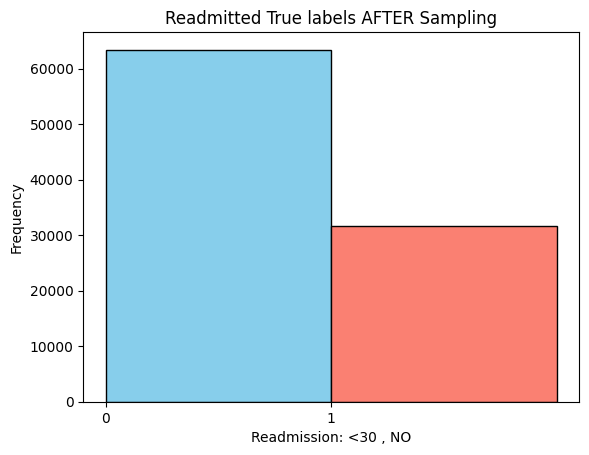

In [ ]:
plot_frequencies(df_resampled.select(labelCol), title="Readmitted True labels AFTER Sampling", xlabel="Readmission: <30 , NO",ylabel="Frequency")

In [ ]:
# Random Undersampling
# The "ratio" parameter expresses how frequent the class "base_class" should be w.r.t to the total
def resample(base_features,ratio,class_field,base_class):
    pos = base_features.filter(col(class_field)==base_class)
    neg = base_features.filter(col(class_field)!=base_class)
    total_pos = pos.count()
    total_neg = neg.count()
    fraction=float(total_pos*ratio)/float(total_neg)
    sampled = neg.sample(False,fraction)
    return sampled.union(pos)

In [ ]:
df_resampled = resample(df_resampled,ratio = 2,class_field = labelCol,base_class = 1)

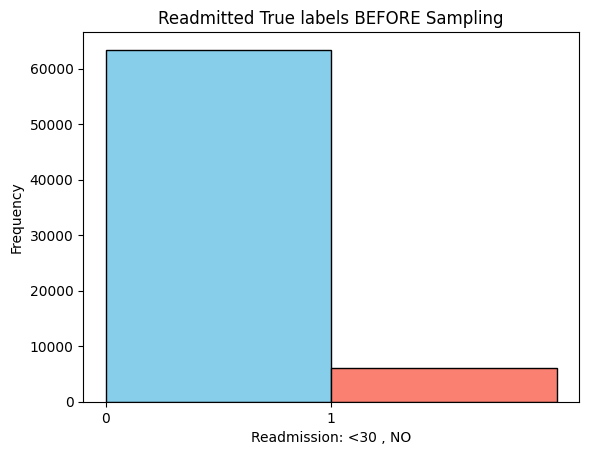

In [ ]:
plot_frequencies(df_encoded.select(labelCol), title="Readmitted True labels BEFORE Sampling", xlabel="Readmission: <30 , NO",ylabel="Frequency")

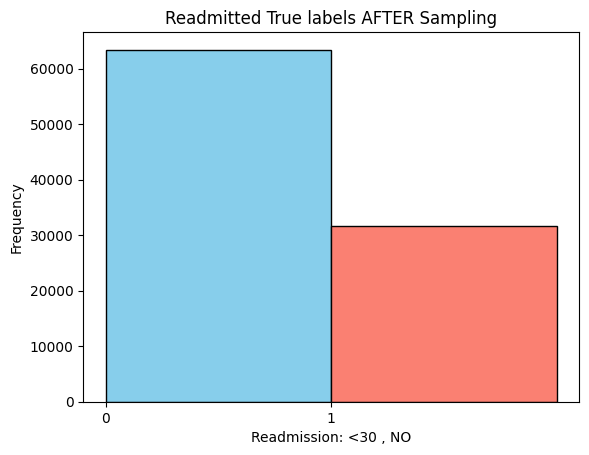

In [ ]:
plot_frequencies(df_resampled.select(labelCol), title="Readmitted True labels AFTER Sampling", xlabel="Readmission: <30 , NO",ylabel="Frequency")

In [ ]:
df_resampled.groupby('readmitted_encoded').count().show()

+------------------+-----+
|readmitted_encoded|count|
+------------------+-----+
|               0.0|63415|
|               1.0|31708|
+------------------+-----+



In this way we rebalanced the class labels to be respectively:
*   0 : 66% of the total
*   1 : 33% of the total


We chose to apply this ratio as we aim to keep the occurrence of the readmission within 30 days as a rarer event compared to the others. Also it led to better results experimentally speaking.



In [ ]:
# statistics
stats = df_resampled.describe(df_resampled.columns)
stats.show()

+-------+------------------+------------------------+-------------------+-----------------+------------------+------------------+-----------------+------------------+-------------------+-------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+---------------------+------------------+------------------+--------------------+--------------------+----------------------+-------------------+---------------------+------------------+-------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------------------+---------------------------+-------------------------------+------------------------------+-------------------+-------------------+-------------------+
|summary| admission_type_id|discharge_disposition_id|admission_source_id| time_in_hospital|num_lab_procedures| 

### Model Definition

In [ ]:
assembler = VectorAssembler(inputCols=cols, outputCol='features')
assembled_df = assembler.transform(df_resampled)

In [ ]:
train_data, test_data = assembled_df.randomSplit([0.7, 0.3], seed=42)

In [ ]:
class PolynomialLogisticRegression:
  def __init__(self,spark=spark,labelCol = labelCol, featuresCol=featuresCol,degree = 3):
    self.spark = spark
    self.degree = degree
    self.featuresCol = featuresCol
    self.labelCol = labelCol
    self.fit = None
    self.poly_expansion = PolynomialExpansion(degree=degree, inputCol=featuresCol, outputCol="poly_features")

  def fit_(self,data):
    # Create a PolynomialExpansion transformer to generate polynomial features
    train_poly = self.poly_expansion.transform(data)
    reg = LogisticRegression(featuresCol='poly_features', labelCol=labelCol, maxIter=10)
    self.fit= reg.fit(train_poly)
    return self

  def transform_(self,data):
    try:
      if(self.fit == None):
        raise "You should call the method fit() first"
      test_poly = self.poly_expansion.transform(data)
      preds = self.fit.transform(test_poly)
      return preds
    except Exception as e:
      print(e)

In [ ]:
# Logistic Regression
lr = LogisticRegression(featuresCol=featuresCol, labelCol=labelCol, maxIter=10)

# Polynomial Logistic Regression
plr = PolynomialLogisticRegression(featuresCol = featuresCol, labelCol=labelCol)

# Decision Tree
dt = DecisionTreeClassifier(featuresCol=featuresCol, labelCol=labelCol)

# Random Forest binary classification
rf = RandomForestClassifier(featuresCol=featuresCol, labelCol=labelCol, numTrees=100, seed=random_state)

# GBTClassifier for binary classification
gbt = GBTClassifier(featuresCol=featuresCol, labelCol=labelCol, maxIter=10, seed=random_state)

# Support Vector Machines (SVM) for binary classification
svm = LinearSVC(featuresCol=featuresCol, labelCol=labelCol)

# Naive Bayes
nb = NaiveBayes(featuresCol=featuresCol, labelCol=labelCol)

# MultilayerPerceptron
nn = MultilayerPerceptronClassifier(featuresCol=featuresCol, labelCol=labelCol, layers=[len(cols), len(cols), 2])

models = [lr,plr,dt,rf,gbt,svm,nb,nn]

### Metric

In [ ]:
def metric(data, labelCol=labelCol,labelPred='prediction'):
  # Calculate True Positive, False Positive, and False Negative
  true_positive = data.filter((data[labelCol] == 1) & (data[labelPred] == 1)).count()
  false_positive = data.filter((data[labelCol] == 0) & (data[labelPred] == 1)).count()
  false_negative = data.filter((data[labelCol] == 1) & (data[labelPred] == 0)).count()

  # Small constant to prevent divisions by 0
  alpha = 0.001

  # Calculate Sensitivity, Precision, and Recall
  recall = round(true_positive / (true_positive + false_negative + alpha),3)
  precision = round(true_positive / (true_positive + false_positive + alpha),3)
  f1_score = round(2*precision*recall/(precision + recall + alpha),3)

  # EValuator
  evaluator = BinaryClassificationEvaluator(labelCol=labelCol)

  # Accuracy
  accuracy = round(evaluator.evaluate(data),3)
  return {
          'accuracy':accuracy,
          'precision':precision,
          'recall':recall,
          'F1_score': f1_score
          }

### Training

In [ ]:
# Logistic regression
lr_preds = lr.fit(train_data).transform(test_data)

# Polynomial Logistic Regression
plr_preds = plr.fit_(train_data).transform_(test_data)

# Decision Tree
dt_preds = dt.fit(train_data).transform(test_data)

# Random Forest
rf_preds = rf.fit(train_data).transform(test_data)

# Gradient boost
gbt_preds = gbt.fit(train_data).transform(test_data)

# Support Vector Machine
svm_preds = svm.fit(train_data).transform(test_data)

# Navive Bayes
nb_preds = nb.fit(train_data).transform(test_data)

# MultiLayerPerceptron
nn_preds = nn.fit(train_data).transform(test_data)

preds = [lr_preds,plr_preds,dt_preds,rf_preds,gbt_preds,svm_preds,nb_preds,nn_preds]

In [ ]:
results = [{'Model':type(models[i]).__name__,**metric(preds[i])} for i in range(len(preds))]

In [ ]:
results_ = spark.createDataFrame(results)
results_.select(['Model','accuracy','F1_score','precision','recall']).show()

+--------------------+--------+--------+---------+------+
|               Model|accuracy|F1_score|precision|recall|
+--------------------+--------+--------+---------+------+
|  LogisticRegression|   0.622|   0.031|    0.412| 0.016|
|PolynomialLogisti...|   0.805|   0.507|    0.926| 0.349|
|DecisionTreeClass...|   0.714|   0.769|      1.0| 0.625|
|RandomForestClass...|   0.888|   0.685|      1.0| 0.521|
|       GBTClassifier|   0.898|   0.826|      1.0| 0.705|
|           LinearSVC|   0.567|     0.0|      0.0|   0.0|
|          NaiveBayes|   0.565|   0.323|    0.414| 0.265|
|MultilayerPercept...|   0.598|   0.117|    0.511| 0.066|
+--------------------+--------+--------+---------+------+

